In [71]:
%%HTML
<style>
    div.prompt {display:none}
       .container {width:90%}
</style>

In [3]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from scipy.stats import dirichlet, norm
import numpy_indexed as npi
from scipy.stats import mode

In [136]:
class DataGenerator:
    def __init__(self, n_cells, n_cell_types, n_genes, K, epsilon=0.25):
        self.n_cells = n_cells
        self.n_cell_types = n_cell_types
        self.n_genes = n_genes
        self.K = K
        self.epsilon = epsilon

        self.graph = None
        self.coordinates = None
        self.neighbors_cell_types = None
        self.perturbation = None
        self.expression = None
        self.cell_types = None
        
        self.reset()

    def reset(self):
        self.generate_cell_caracteristics()
        self.generate_perturbation()
        self.generate_knn_graph()
        self.generate_cell_types()
        self.generate_perturbed_caracteristics()

    def generate_knn_graph(self):
        self.coordinates = np.random.uniform(size=(self.n_cells, 2))
        nn = NearestNeighbors(self.K + 1)
        nn.fit(self.coordinates)
        self.graph = nn.kneighbors(self.coordinates, self.K + 1)[1][:, 1:]
        
        self.graph_reversed = [[] for _ in range(self.n_cells)]
        for v, nbs in enumerate(self.graph):
            for u in nbs:
                self.graph_reversed[u].append(v)
        self.graph_reversed = [np.array(nbs) for nbs in self.graph_reversed]
        
        self.adjacency = nn.kneighbors_graph()

    def generate_cell_types(self):
        self.cell_types = np.random.choice(self.n_cell_types, size=self.n_cells)
        self.neighbors_cell_types = np.zeros((self.n_cells, self.n_cell_types))
        for i in range(self.n_cells):
            cell_types, counts = np.unique(
                self.cell_types[self.graph[i]], return_counts=True
            )
            self.neighbors_cell_types[i][cell_types] = counts / self.K

    def generate_perturbation(self):
        shape = (self.n_cell_types, self.n_cell_types, self.n_genes)
        self.perturbation = np.random.normal(0, 10, size=shape)

    def generate_cell_caracteristics(self):
        shape = self.n_cell_types, self.n_genes
        self.initial_cell_carac = np.random.normal(0, 10, size=shape)

    def generate_perturbed_caracteristics(self):
        effective_perturbation = (
            self.perturbation[self.cell_types]
            * self.neighbors_cell_types[:, :, np.newaxis]
        ).sum(axis=1)

        self.effective_gene_expression = (
            self.initial_cell_carac[self.cell_types]
            + self.epsilon * effective_perturbation
        )

    def generate_gene_expression(self, epsilon=None, n_cells=None):
        # If epsilon or n_cells is given, resample accordingly without changing the
        # global latent variable about cluster mean, cluster interactions
        if n_cells is not None:
            self.n_cells = n_cells
            self.generate_knn_graph()
            self.generate_cell_types()

        if epsilon is not None:
            self.epsilon = epsilon
            self.generate_perturbed_caracteristics()

        self.observations = np.random.normal(self.effective_gene_expression, 1)
        return self.observations
    

In [525]:
class GibbsSampler:
    def __init__(
        self,
        data_generator,
        sigma=10,
        S=1,
        alpha=None,
        
    ):
        self.n_cells = dg.n_cells
        self.n_cell_types = dg.n_cell_types
        self.n_genes = dg.n_genes
        self.epsilon = dg.epsilon
        self.graph = dg.graph
        self.graph_reversed = dg.graph_reversed
        self.dg = data_generator
        
        self.epsilon_up = self.epsilon / self.graph.shape[1]
        self.sigma = sigma
        self.S = S
        self.Vi = None
        self.neighbors_cell_types = None
        if alpha is None:
            alpha = np.ones(n_cell_types)
        self.alpha = alpha
        self.cluster_truth = dg.cell_types
        self.reset()

    def reset(self):
        self.pi = np.random.dirichlet(self.alpha)
        self.set_Z(
            np.random.choice(self.n_cell_types, p=self.pi, size=self.n_cells)
        )
        self.beta = np.random.normal(
            0, self.sigma, size=(self.n_cell_types, self.n_genes)
        )
        self.rho = np.random.normal(
            0,
            self.sigma,
            size=(self.n_cell_types, self.n_cell_types, self.n_genes),
        )
        self.log_joints = []
        self.cluster_score = []

    def set_Z(self, Z):
        self.Z = Z.astype(int)

        # Count types
        self.n_i = np.zeros(self.n_cell_types)
        cell_types, counts = np.unique(self.Z, return_counts=True)
        self.n_i[cell_types] = counts

        # Reverse map each type l: list of cells having type l
        values, indices = npi.group_by(self.Z, np.arange(self.n_cells))
        self.Vi = [np.array([]) for _ in range(self.n_cell_types)]
        for i, v in enumerate(values):
            self.Vi[v] = indices[i]

        # For each cell v, number of neighbors of type k
        self.mvk = np.zeros((self.n_cells, self.n_cell_types))
        for i in range(self.n_cells):
            cell_types, counts = np.unique(self.Z[self.graph[i]], return_counts=True)
            self.mvk[i][cell_types] = counts

        # Count number of edge k->l (in l,k)
        self.ctype_ctype_counts = np.zeros((self.n_cell_types, self.n_cell_types))
        for l in range(self.n_cell_types):
            if len(self.Vi[l]):
                self.ctype_ctype_counts[l] = self.mvk[self.Vi[l]].sum(axis=0)

    def sample_pi(self):
        return np.random.dirichlet(self.alpha + self.n_i)

    def sample_beta(self, x):
        multipliers = self.sigma ** 2 / (self.S ** 2 + self.n_i * self.sigma ** 2)

        variances = (self.S ** 2) * multipliers
        alphas = np.array(
            [
                (x[self.Vi[i]].sum(axis=0) if len(self.Vi[i]) else 0)
                - self.epsilon_up
                * (self.rho[i, :, :] * self.ctype_ctype_counts[i, :, None]).sum(axis=0)
                for i in range(self.n_cell_types)
            ]
        )

        return np.random.normal(
            multipliers[:, None] * alphas, np.sqrt(variances)[:, None]
        )

    def sample_rho(self, x):
        eta = 1.0 / (
            self.S ** 2 / self.sigma ** 2
            + self.epsilon_up ** 2
            * np.array(
                [
                    (self.mvk[self.Vi[i]] ** 2).sum(axis=0)
                    if len(self.Vi[i])
                    else np.zeros((self.n_cell_types))
                    for i in range(self.n_cell_types)
                ]
            )
        )

        t = self.epsilon_up * np.array(
            [
                [
                    np.sum(
                        (
                            self.mvk[:, k, None]
                            * (
                                x
                                - self.beta[i, None, :]
                                - self.epsilon_up
                                * np.sum(
                                    self.rho[i, self.Z[self.graph], :]
                                    * (self.Z[self.graph] != k)[:, :, None],
                                    axis=1,
                                )
                            )
                        )
                        * (self.Z == i)[:, None],
                        axis=0,
                    )
                    for k in range(self.n_cell_types)
                ]
                for i in range(self.n_cell_types)
            ]
        )

        #         for i in range(self.n_cell_types):
        #             mu[i] = self.epsilon_up * (
        #                 self.mvk[self.Vi[i]].sum(axis=0) if len(self.Vi[i]) else np.zeros((self.n_cell_types))
        #             )
        return np.random.normal(
            eta[:, :, None] * t, np.sqrt((self.S ** 2) * eta[:, :, None])
        )

    def log_pz(self, x, v, k):
        # logp(z_v = k) + constant
        term1 = (
            (
                self.beta[k]
                - x[v]
                + self.epsilon_up
                * self.rho[self.Z[v]][self.Z[self.graph[v]]].sum(axis=0)
            )
            ** 2
        ).sum()

        neighbors = self.graph_reversed[v]
        if len(neighbors):
            zw = self.Z[neighbors]
            old_zv = self.Z[v]
            self.Z[v] = k

            term2 = (
                (
                    self.beta[zw]
                    - x[neighbors]
                    + self.epsilon_up
                    * self.rho[zw[:, None], self.Z[self.graph[neighbors]], :].sum(
                        axis=1
                    )
                )
                ** 2
            ).sum()

            self.Z[v] = old_zv
        else:
            term2 = 0

        return term1 + term2

    def sample_Z(self, x):
        log_vals = np.array(
            [
                [
#                                         self._log_joint(
#                                             x, self.Z + (k - self.Z[i]) * (np.arange(self.n_cells) == i)
#                                         )
                    - self.log_pz(x, i, k) + np.log(self.pi[k])
                    for k in range(self.n_cell_types)
                ]
                for i in range(self.n_cells)
            ]
        )
        log_vals -= np.max(log_vals, axis=1)[:, None]
        probas = np.exp(log_vals) / np.sum(np.exp(log_vals), axis=1)[:, None]
        return np.array(
            [
                np.random.choice(np.arange(self.n_cell_types), p=probas[v])
                for v in range(self.n_cells)
            ]
        )

    """
        This function computes the log-joint for a specified Z, which is used while sampling Z. 
        To get the log-joint for the current value of the parameters, use log_joint
    """

    
    def _log_joint(self, x, Z):
        temp = (
            dirichlet.logpdf(self.pi, self.alpha)
            + np.sum(np.log(self.pi[Z]))
            + np.sum(norm.logpdf(self.beta, 0, self.sigma))
            + np.sum(norm.logpdf(self.rho, 0, self.sigma))
        )
        loc = np.array(
            [
                self.beta[Z[v], :]
                + self.epsilon_up * np.sum(self.rho[Z[v], Z[self.graph[v]], :], axis=0)
                for v in range(self.n_cells)
            ]
        )
        return temp + np.sum(norm.logpdf(x, loc, self.S * np.ones(loc.shape)))

    def log_joint(self, x):
        return self._log_joint(x, self.Z)
    
    def cold_start(self, x, n_epochs=10, n_samples=15, seed=0):
        scores = []
        for i in range(n_samples):
            np.random.seed(seed+i)
            self.reset()
            self.train(n_epochs, x, False)
            scores.append((self.log_joint(x), i))
        _, i = max(scores)
        
        np.random.seed(seed+i)
        self.reset()
        self.train(n_epochs, x)
        
        return max(scores), min(scores)
            
            

    def train(self, num_epochs, x, log_scores=True):
        for ep in range(num_epochs):
            self.set_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            if log_scores and ep % 10 == 0:
                self.log_joints.append(self.log_joint(x))
                self.cluster_score.append(normalized_mutual_info_score(self.Z, self.cluster_truth))

    def plot(self):
        plt.plot(np.arange(len(self.log_joints)), self.log_joints)

In [100]:
n_cells = 500
n_cell_types = 4
n_genes = 2
K = 3
epsilon = 0.73
np.random.seed(2)

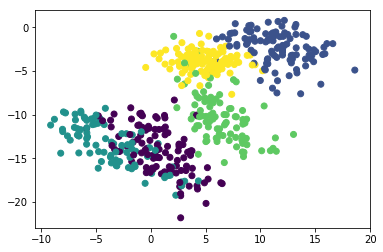

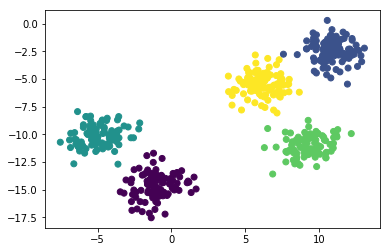

In [250]:
n_cells = 500
n_cell_types = 5
n_genes = 2
K = 3
epsilon = 0.4
seed = 22

np.random.seed(seed)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(epsilon, n_cells)

plt.scatter(*expression.T[:2], c=dg.cell_types)
plt.show()
np.random.seed(seed)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(0, n_cells)

plt.scatter(*expression.T[:2], c=dg.cell_types)

np.random.seed(seed)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(epsilon, n_cells)

In [95]:
sampler = GibbsSampler(dg)
sampler.train(100, expression)

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [263]:
dg.epsilon = 0
sampler = GibbsSampler(dg)
sampler.cold_start(expression)

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


((-3813.0760526310783, 1), (-4846.334961094966, 2))

In [264]:
sampler.train(100, expression)

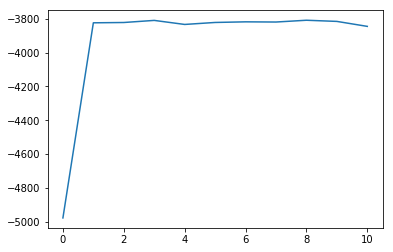

In [265]:
sampler.plot()

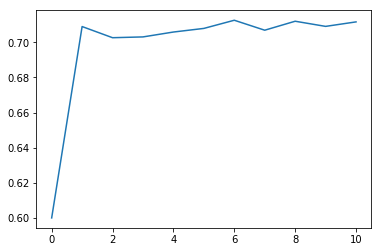

In [266]:
plt.plot(sampler.cluster_score)

In [267]:
sampler.cluster_score[-10:]

[0.7089660676177515,
 0.7026073993095243,
 0.7030607447553393,
 0.705842288345364,
 0.7079025187256763,
 0.7125555498255559,
 0.7068817475566536,
 0.7119928275778658,
 0.7090588182573047,
 0.711616127798648]

In [260]:
sampler.cluster_score[-10:]

[0.7867066278289799,
 0.7948676234561156,
 0.7907799575960981,
 0.7920245246114055,
 0.7920245246114055,
 0.7934192411930333,
 0.7891295530547535,
 0.7961956359706512,
 0.7947317216588469,
 0.7885194110989835]

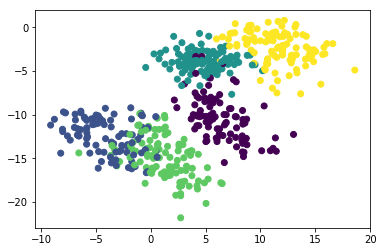

In [262]:
plt.scatter(*expression.T[:2], c=sampler.Z)

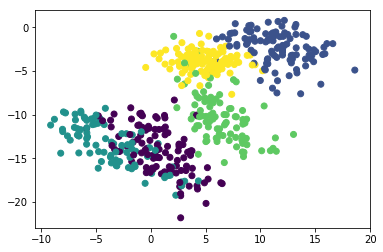

In [269]:
plt.scatter(*expression.T[:2], c=dg.cell_types)

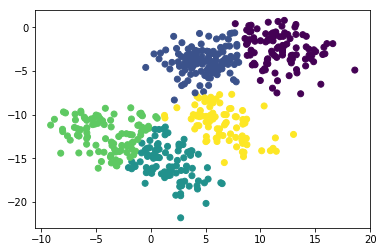

In [268]:
plt.scatter(*expression.T[:2], c=sampler.Z)

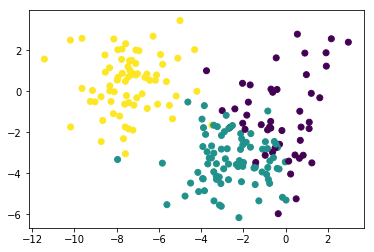

In [182]:
plt.scatter(*expression.T[:2], c=sampler.Z)

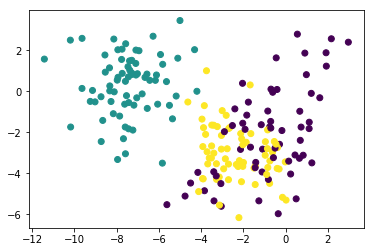

In [183]:
plt.scatter(*expression.T[:2], c=dg.cell_types)

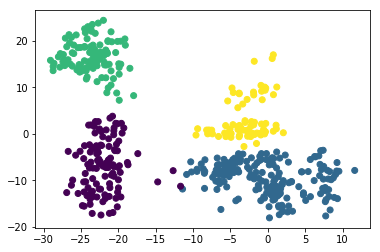

In [117]:
plt.scatter(*expression.T[:2], c=km.labels_)

In [84]:
sampler.train(200, expression)

In [ ]:
sampler.rho = dg.perturbation
sampler.Z = dg.cell_types
sampler.beta = dg.initial_cell_carac

In [25]:
from collections import defaultdict

In [15]:
from sklearn.metrics import normalized_mutual_info_score

In [26]:
def sample(sampler, n_samples = 10):
    res = defaultdict(list)
    for _ in range(n_samples):
        sampler.train(25, expression)
        res["rho"].append(sampler.rho)
        res["beta"].append(sampler.beta)
        res["z"].append(sampler.Z)
        res["pi"].append(sampler.pi)
    for k in res:
        res[k] = np.array(res[k])
    return res
    

In [40]:
s = sample(sampler, 5)

In [28]:
0

0

In [41]:
clusters_pred = mode(s["z"], axis=0).mode[0]
groundtruth = dg.cell_types
normalized_mutual_info_score(clusters_pred, groundtruth)

0.6657362114449356

In [42]:
from sklearn.cluster import KMeans

In [44]:
km = KMeans(n_cell_types)
km.fit(expression)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
normalized_mutual_info_score(km.labels_, groundtruth)

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8098738131424363

In [536]:
normalized_mutual_info_score(clusters_pred, groundtruth)

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0

In [538]:
np.random.seed(2)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
    

In [540]:
score = []
for epsilon in np.linspace(0, 2, 20):
    expression = dg.generate_gene_expression(epsilon, n_cells)
    sampler = GibbsSampler(n_cells, n_cell_types, n_genes, 10, 1, epsilon, dg.graph, dg.graph_reversed)
    sampler.train(100, expression)
    
    s = sample(sampler, 10)
    clusters_pred = mode(s["z"], axis=0).mode[0]
    groundtruth = dg.cell_types
    score.append(normalized_mutual_info_score(clusters_pred, groundtruth, average_method='geometric'))
    print(epsilon, score[-1])
    

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.10526315789473684 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.21052631578947367 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.3157894736842105 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.42105263157894735 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5263157894736842 0.4771673250494859


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.631578947368421 0.7567895510026084


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.7368421052631579 0.352292898493842


KeyboardInterrupt: 

In [ ]:
np

In [272]:
np.random.dirichlet((1,1,1,1), (10)).shape

(10, 4)

In [452]:
class CAVI:
    def __init__(self, data_generator, x, sigma=10, S=1, alpha=None):
        self.n_cells = data_generator.n_cells
        self.n_cell_types = data_generator.n_cell_types
        self.n_genes = data_generator.n_genes
        self.epsilon = data_generator.epsilon
        self.graph = data_generator.graph
        self.graph_reversed = data_generator.graph_reversed
        self.dg = data_generator
        self.adjacency = data_generator.adjacency

        self.x = x

        self.epsilon_up = self.epsilon / self.graph.shape[1]
        self.sigma = sigma
        self.S = S
        self.Vi = None
        self.neighbors_cell_types = None
        if alpha is None:
            alpha = np.ones(n_cell_types)
        self.alpha = alpha
        self.cluster_truth = dg.cell_types
        self.reset()

    def reset(self):
        self.delta_pi = np.random.uniform(1, 2, (self.n_cell_types,))
        self.beta_mu = np.random.normal(
            0, self.sigma, size=(self.n_cell_types, self.n_genes)
        )
        self.beta_std = np.random.normal(
            0, self.sigma, size=(self.n_cell_types, self.n_genes)
        )
        self.rho_mu = np.random.normal(
            0, self.sigma, size=(self.n_cell_types, self.n_cell_types, self.n_genes)
        )
        self.rho_std = np.random.normal(
            0, self.sigma, size=(self.n_cell_types, self.n_cell_types, self.n_genes)
        )
        self.set_phis(
            np.random.dirichlet(np.ones(self.n_cell_types), size=self.n_cells)
        )
        self.log_joints = []
        self.cluster_score = []

    def set_phis(self, phis):
        self.phis = phis

        # \sum_v \phi_{vi}
        self.n_i = self.phis.sum(axis=0)

        self.mvk = self.adjacency @ self.phis
        self.mvk2 = self.mvk ** 2 + self.adjacency @ (self.phis * (1 - self.phis))

        # \sum v \sum{w \in N(v)} \phi vi \phi wj
        self.B = self.phis.T @ self.mvk

    def sample_pi(self):
        return np.random.dirichlet(self.alpha + self.n_i)

    def compute_ni(self, x):
        self.ni = self.phis.sum(axis=0)

    def compute_alpha(self, x):
        alpha = self.phis.T @ x

    def update_beta(self):
        cst = self.sigma ** 2 / (self.S ** 2 + self.n_i * self.sigma ** 2)
        alpha_ij = (self.phis.T @ self.x) - self.epsilon_up * np.einsum(
            "ikj,ik->ij", self.rho_mu, self.B
        )
        self.beta_mu = cst[:, None] * alpha_ij

        self.beta_std = (cst * self.S ** 2)[:,]  # Maybe expand?

    def update_rho(self):
        eta_ik = 1.0 / (
            self.S ** 2 / self.sigma ** 2
            + self.epsilon_up ** 2 * self.phis.T @ self.mvk2
        )
        delta_kneql = np.ones((self.n_cell_types, self.n_cell_types)) - np.eye(
            self.n_cell_types
        )

        a_ikj = np.einsum(
            "vi,vk,vj->ikj", self.phis, self.mvk, self.x, optimize="optimal"
        )
        b_ikj = np.einsum(
            "vi,vk,ij->ikj", self.phis, self.mvk, self.beta_mu, optimize="optimal"
        )

        # Need to optimize each k sequentially for correctness
        for k in range(self.n_cell_types):
            c_ikj = np.einsum(
                "ilj,vi,v,vl,l->ij",
                self.rho_mu,
                self.phis,
                self.mvk[:, k],
                self.mvk,
                delta_kneql[k, :],
                optimize="optimal",
            ) - np.einsum(
                "ilj,wi,w,wl,l->ij",
                self.rho_mu,
                (self.adjacency.T @ self.phis),
                self.phis[:, k],
                self.phis,
                delta_kneql[k, :],
                optimize="optimal",
            )

            mu_ikj = self.epsilon_up * (
                a_ikj[:, k, :] - b_ikj[:, k, :] - self.epsilon_up * c_ikj
            )

            self.rho_mu[:, k, :] = eta_ik[:, k, None] * mu_ikj
        self.rho_std = (self.S ** 2 * eta_ik)[:, :, None]

    def update(self):
        self.update_phi()
        self.update_gamma()
        self.update_lambda()

    def run(self, n_epochs):
        for i in tqdm.tqdm_notebook(range(n_epochs)):
            self.update()
            if self.internal_epochs % self.metric_freq == 0:
                log_elbo, log_joint, negative_entropy = self.log_elbo(True)
                self.history.append(log_elbo)
                self.history_entropy.append(-negative_entropy)
                self.history_log_joint.append(log_joint)
                self.history_held_out.append(self.held_out())
            self.internal_epochs += 1

    """
        This function computes the log-joint for a specified Z, which is used while sampling Z. 
        To get the log-joint for the current value of the parameters, use log_joint
    """

    def _log_joint(self, x, Z):
        temp = (
            dirichlet.logpdf(self.pi, self.alpha)
            + np.sum(np.log(self.pi[Z]))
            + np.sum(norm.logpdf(self.beta, 0, self.sigma))
            + np.sum(norm.logpdf(self.rho, 0, self.sigma))
        )
        loc = np.array(
            [
                self.beta[Z[v], :]
                + self.epsilon_up * np.sum(self.rho[Z[v], Z[self.graph[v]], :], axis=0)
                for v in range(self.n_cells)
            ]
        )
        return temp + np.sum(norm.logpdf(x, loc, self.S * np.ones(loc.shape)))

    def log_joint(self, x):
        return self._log_joint(x, self.Z)

    def cold_start(self, x, n_epochs=10, n_samples=15, seed=0):
        scores = []
        for i in range(n_samples):
            np.random.seed(seed + i)
            self.reset()
            self.train(n_epochs, x, False)
            scores.append((self.log_joint(x), i))
        _, i = max(scores)

        np.random.seed(seed + i)
        self.reset()
        self.train(n_epochs, x)

        return max(scores), min(scores)

    def train(self, num_epochs, x, log_scores=True):
        for ep in range(num_epochs):
            self.set_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            if log_scores and ep % 10 == 0:
                self.log_joints.append(self.log_joint(x))
                self.cluster_score.append(
                    normalized_mutual_info_score(self.Z, self.cluster_truth)
                )

    def plot(self):
        plt.plot(np.arange(len(self.log_joints)), self.log_joints)

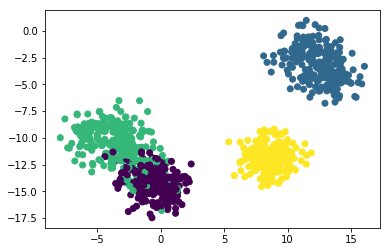

In [418]:
n_cells = 1000
n_cell_types = 4
n_genes = 2
K = 3
epsilon = 0.2
seed = 22

np.random.seed(seed)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(epsilon, n_cells)

plt.scatter(*expression.T[:2], c=dg.cell_types)


In [453]:
cavi = CAVI(dg, expression)

In [454]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [489]:
cavi.phis = get_one_hot(dg.cell_types, dg.n_cell_types)
cavi.beta_mu = dg.initial_cell_carac

In [516]:

cavi.update_rho()

cavi.rho_mu

array([[[ 1.65258316,  2.03161393],
        [ 1.09616627,  1.79338869],
        [-0.56872499,  1.28950908],
        [ 2.30752387,  0.74193053]],

       [[ 5.51761532, -2.67201859],
        [ 4.05350904, -1.20942385],
        [ 6.17587237, -3.63478867],
        [ 5.45795234, -2.52958572]],

       [[ 5.43861492, -1.579251  ],
        [ 4.09671655, -3.06005068],
        [ 4.44438421, -2.30770453],
        [ 5.27385637, -1.56732511]],

       [[-1.45932699, -2.99457694],
        [-1.47233621, -3.23329018],
        [-1.86493509, -2.46230878],
        [-2.98776983, -2.29723233]]])

In [545]:
sampler = GibbsSampler(dg)
#sampler.cold_start(expression)

In [546]:
sampler.Z = dg.cell_types
sampler.beta = dg.initial_cell_carac

In [551]:
sampler.pi *= 0
sampler.pi += 0.25

In [552]:
for _ in range(50):
    # sampler.set_Z(sampler.sample_Z(expression))
    sampler.rho = sampler.sample_rho(expression)
    
    print(sampler.log_joint(expression))

-3.614009757531517e+88
-1.752664894910014e+90
-8.499795075119245e+91
-4.1220952464350416e+93
-1.9990681034676578e+95
-9.694762113412882e+96
-4.7016113294304505e+98
-2.2801125839329137e+100
-1.1057726875179666e+102
-5.362600272797239e+103
-2.600668474671271e+105
-1.261230778183852e+107
-6.116516162404405e+108
-2.9662905958278754e+110
-1.438544371545983e+112
-6.976423388245497e+113
-3.3833147071962287e+115
-1.640786083484687e+117
-7.957223033467206e+118
-3.8589672987637784e+120
-1.8714605020238415e+122
-9.075911090921436e+123
-4.401490816462945e+125
-2.1345649173212402e+127
-1.0351872981800618e+129
-5.020286493128308e+130
-2.434658589551457e+132
-1.1807219479984358e+134
-5.726077259736282e+135
-2.7769417550043193e+137
-1.3467169863233083e+139
-6.5310935599688604e+140
-3.1673457394727196e+142
-1.5360488930744737e+144
-7.449285288028271e+145
-3.612635740478609e+147
-1.751998546002509e+149
-8.496563522311423e+150
-4.120528059420531e+152
-1.9983080740686324e+154
-9.691076243876987e+155
-4.69

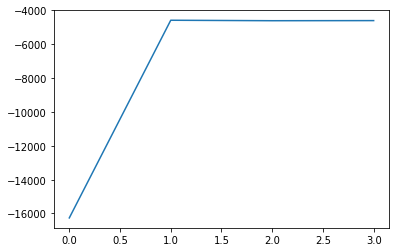

In [521]:
sampler.plot()

In [486]:
dg.perturbation

array([[[  6.26493456,  -5.61513781],
        [  0.28855118,  -2.30767188],
        [  5.87752215,   7.52317579],
        [-10.58502554,  10.55972414]],

       [[  7.47750266,  10.64676588],
        [ 15.20129588, -14.88602936],
        [ 18.59989892, -15.98613027],
        [ -6.46073613,   3.37325002]],

       [[ 10.46728725,   6.2914334 ],
        [  3.63059095,   5.55749697],
        [-10.88549532,   0.23694772],
        [ 24.99176641, -24.90030393]],

       [[ -2.34862387,  -0.9756346 ],
        [ -8.86529342,  -1.36713238],
        [  1.01978927,  -2.50929536],
        [ -0.78812304, -10.85164166]]])

In [415]:
cavi.beta_mu

array([[ -0.64703165, -15.9798994 ],
       [ 11.51643251,  -2.93266031],
       [ -3.4777503 , -10.82710632],
       [  8.0409688 , -11.1236459 ]])

In [403]:
dg.initial_cell_carac

array([[ -0.9194992 , -14.63350653],
       [ 10.81791679,  -2.39325168],
       [ -4.91129136, -10.0227201 ],
       [  9.18821503, -11.03632101]])

In [ ]:
cavi

In [318]:
cavi.phis

array([[0.15792611, 0.23874063, 0.16503617, 0.18988806, 0.24840902],
       [0.16672093, 0.21476744, 0.26101945, 0.07400819, 0.28348399],
       [0.54929278, 0.24489633, 0.02154183, 0.07061969, 0.11364937],
       ...,
       [0.12315526, 0.49124535, 0.10473061, 0.07980022, 0.20106857],
       [0.4205168 , 0.03643199, 0.07207726, 0.03841351, 0.43256043],
       [0.0546618 , 0.11510027, 0.09685103, 0.38539042, 0.34799647]])

In [317]:
cavi.update_beta()

In [298]:
tmp = np.ones((cavi.n_cell_types, cavi.n_cell_types)) - np.eye((cavi.n_cell_types))

In [284]:
print(cavi.rho_mu.shape)
print(cavi.phis.shape)
print(cavi.adjacency.shape)


(5, 5, 2)
(500, 5)
(500, 500)


In [299]:
A = cavi.adjacency.todense()

In [305]:
np.einsum("vi,xk,wl,ilj,lk,vx,vw->ikj", cavi.phis, cavi.phis, cavi.phis, cavi.rho_mu, tmp, A, A, optimize='optimal')

array([[[-1321.9312075 , -1066.7302316 ],
        [  106.31372114,   121.03123727],
        [-1096.17424935,  -558.48846227],
        [ -950.89810589,  -490.51574622],
        [  400.36741059,  -289.77507487]],

       [[  746.44540079,   245.33433886],
        [ -936.197824  ,  -256.71807198],
        [ -207.03194002,  -137.05737323],
        [  176.80822205,  -559.16249599],
        [ -773.23090618,  -261.30978312]],

       [[ -289.0613698 ,  1885.93302199],
        [-1087.31692446,  1012.41370844],
        [  578.60883281,  2202.64982292],
        [-1294.96884374,  2286.60351372],
        [ -975.15049971,  1168.53603726]],

       [[  816.42423074,  -841.70384369],
        [  518.08016289, -2378.80922475],
        [  710.5474727 ,  -420.47065539],
        [ -803.32285076, -1752.96932554],
        [ -791.90601067,  -809.07093099]],

       [[-1639.85312974,  -310.54854218],
        [-1697.72320003,  -504.85526321],
        [ -900.05807582,  -731.16451737],
        [-1280.16771284,  

In [295]:
np.einsum("ilj,vi,vw,wk,wl->ikj", cavi.rho_mu, cavi.phis, cavi.adjacency.todense(), cavi.phis, cavi.phis, optimize='optimal')

array([[[ -63.01634846,  -32.24589531],
        [-364.03035542, -306.8849561 ],
        [ -89.60361018, -134.40980337],
        [ -75.13488052, -128.57203477],
        [-354.88380609, -159.3198473 ]],

       [[-245.53333271, -142.42287875],
        [  92.87275165,  -58.67031919],
        [ -47.73342616,  -67.88431632],
        [-175.68253063,    3.91046568],
        [  43.45851639,  -54.61696334]],

       [[-255.37879105,  534.91169379],
        [-120.03942282,  762.97368618],
        [-458.76545307,  462.92877584],
        [ -58.3332852 ,  413.23097685],
        [-119.35173504,  618.40492669]],

       [[ -90.36917342, -495.97682142],
        [ -80.55913918, -202.54939507],
        [-113.37833831, -560.86427963],
        [ 191.62789012, -274.99733471],
        [ 177.41846696, -463.19984552]],

       [[-379.89535702, -190.85414243],
        [-368.01627745, -129.7598574 ],
        [-491.86352617,  -66.52566633],
        [-406.67673714,  -86.79377118],
        [-444.76132805, -230.174

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1]])

In [592]:
s["rho"].std(axis=0)[1,1]

array([0.86975205, 1.14438111, 2.19133842, 1.39400151, 1.28254947,
       0.71119764])

In [593]:
s["rho"].mean(axis=0)[1,1]

array([-11.94664252,  19.9109246 ,  20.41798479,  -3.59231231,
         7.56142889,  -0.15291544])

In [594]:
dg.perturbation[1,1]

array([-18.68090655,  17.31184666,  14.67678011,  -3.35677339,
         6.1134078 ,   0.47970592])

In [83]:
sampler.Z

array([1, 1, 1, 0, 1, 0, 2, 1, 2, 0])

In [84]:
dg.cell_types

array([0, 0, 0, 1, 0, 1, 2, 0, 2, 1])

In [74]:
gs = GibbsSamplerO(expression, 3)

In [75]:
gs.run_gibbs(100)

[-3401.748983306175,
 -54.916211294836316,
 -51.59809172499874,
 -49.07265200216855,
 -56.10167814061352,
 -51.52813875663723,
 -53.81353752714547,
 -54.606687248189786,
 -52.557764608237086,
 -59.16501729772925,
 -47.61986065806933,
 -55.77690676399175,
 -55.3966444221681,
 -49.58302740791405,
 -52.84935263562221,
 -50.48625987901906,
 -54.081470862860755,
 -55.036087668050484,
 -58.95000326025008,
 -49.91075351089705,
 -56.758703165533475,
 -49.40577401900014,
 -51.58808436325172,
 -53.670682669272885,
 -59.967954526825984,
 -53.44730879971517,
 -51.34973788039145,
 -50.30806285483588,
 -55.170031077681266,
 -51.86715520231809,
 -52.114049391170774,
 -48.757991692402314,
 -51.87268754151549,
 -55.332945275087994,
 -51.571922911028494,
 -49.802607168480726,
 -54.79065614218608,
 -59.74482858127561,
 -53.517063519974975,
 -53.93223384348598,
 -51.78100695461344,
 -53.62428786472539,
 -52.077436537071975,
 -50.116266137424574,
 -50.580928371281246,
 -52.5916317685823,
 -53.9527699096377

In [76]:
gs.latent_variables[]

{'theta': array([0.17824664, 0.28579064, 0.53596272]), 'z': array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]]), 'beta': array([[ -4.39083358,   0.0798692 ,  -8.57207756,   0.2591827 ,
          -5.23157991],
        [-13.41583285,   7.95059077,   9.18353537,  14.98887881,
           1.45680536],
        [ 17.40763078,   3.76452611,   1.82834145, -18.50243235,
          -3.90154086]])}

In [ ]:
for k in range(self.n_cell_types):
            c_ikj = (
                np.einsum(
                    "ilj,vi,vk,vl,kl->ikj",
                    self.rho_mu,
                    self.phis,
                    self.mvk,
                    self.mvk,
                    delta_kneql,
                    optimize="optimal",
                )
                - np.einsum(
                    "ilj,wi,wk,wl,kl->ikj",
                    self.rho_mu,
                    (self.adjacency.T @ self.phis),
                    self.phis,
                    self.phis,
                    delta_kneql,
                    optimize="optimal",
                )
            )

            mu_ikj = self.epsilon_up * (a_ikj - b_ikj - self.epsilon_up * c_ikj)

            self.rho_mu = eta_ik[:,:,None] * mu_ikj
            self.rho_std = (self.S**2 * eta_ik)[:,:,None]